# Answers

Import standard libraries and the class `Loans_Portfolio` from `portfolio_model` which is our custom class for this project.

In [50]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from case.portfolio_model import Loans_Portfolio

The following are just optional configurations.

In [50]:
mystyle = 'style/pastel-light.mplstyle'
plt.style.use(mystyle)
%config InlineBackend.figure_format='retina'
pd.options.mode.copy_on_write = True 
pd.options.display.float_format = "{:,.2f}".format

Create the `Loans_Portfolio` object, passin the cob date as well as the spreadsheet location.
We assume that the spreadsheet is in the same format as the one provided.

In [51]:
cob = datetime.date(2022, 12, 31)  # 31/12/2022
ss_path = 'data/2024_Strat_Casestudy.xlsx'
portfolio = Loans_Portfolio(cob_date=cob, data_path=ss_path)

Question 1: Consolidate the Static and Historic Data provided into a single pandas dataframe to allow for easier data exploration and facilitate future analysis.

The dataframe should be of the format where there is a row per loan per calendar month.

In [52]:
portfolio.consolidate_data()

The consolidated data can be seen as follows

In [53]:
consolidated_data = portfolio.data

In [54]:
consolidated_data.head()

,loan_id,level_1,Balance,Payment_Due,Payment_Made,origination_date,investor_1_acquisition_date,reversion_date,original_balance,product,pre_reversion_fixed_rate,post_reversion_boe_margin
0,1,2020-12-31,"150,876.00",NaN,NaN,2020-12-31,2020-12-31,2022-12-31,150876,1,0.02,0.04
1,1,2021-01-31,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,0.02,0.04
2,1,2021-02-28,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,0.02,0.04
3,1,2021-03-31,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,0.02,0.04
4,1,2021-04-30,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,0.02,0.04


In [55]:
consolidated_data.describe()

,loan_id,level_1,Balance,Payment_Due,Payment_Made,origination_date,investor_1_acquisition_date,reversion_date,original_balance,product,pre_reversion_fixed_rate,post_reversion_boe_margin
count,"42,611.00",42611,"42,611.00","37,170.00","37,170.00",42611,42611,42611,"42,611.00","42,611.00","42,611.00","42,611.00"
mean,866.32,2021-05-20 17:39:24.657013504,"135,323.46",370.39,"1,694.07",2019-10-09 23:02:16.781582336,2021-03-07 14:39:33.527962112,2021-10-09 09:32:48.590270208,"151,748.79",1.29,0.03,0.03
min,1.00,2016-01-31 00:00:00,0.00,0.00,0.00,2016-01-31 00:00:00,2020-12-31 00:00:00,2018-01-31 00:00:00,"50,244.00",1.00,0.02,0.02
25%,441.00,2020-08-31 00:00:00,"86,145.00",226.09,220.72,2018-09-30 00:00:00,2020-12-31 00:00:00,2020-09-30 00:00:00,"102,895.00",1.00,0.02,0.02
50%,889.00,2021-08-31 00:00:00,"140,448.00",339.61,338.02,2019-11-30 00:00:00,2020-12-31 00:00:00,2021-11-30 00:00:00,"150,368.00",1.00,0.03,0.04
75%,"1,300.00",2022-05-31 00:00:00,"193,355.00",469.95,472.15,2020-12-31 00:00:00,2020-12-31 00:00:00,2022-12-31 00:00:00,"201,128.00",2.00,0.03,0.04
max,"1,630.00",2022-12-31 00:00:00,"249,978.00","1,536.21","248,504.78",2022-12-31 00:00:00,2022-12-31 00:00:00,2024-12-31 00:00:00,"249,978.00",2.00,0.08,0.04
std,484.40,NaN,"71,605.64",199.44,"15,051.62",NaN,NaN,NaN,"57,376.29",0.45,0.01,0.01


Question 2: Please add the following calculated columns to the dataframe (plus any others you found helpful). 

Dynamic Columns (These vary by loan and by calendar month):

- current_balance: The current balance outstanding for each loan and month.
- seasoning: The integer number of months since the loan was originated at each month.
- n_missed_payments: number of missed payments in a row.
- prepaid_in_month: a flag indicating that the borrower prepaid in a given month.
- default_in_month: a flag indicating that the borrower defaulted in a given month.
- recovery_in_month: a flag indicating that a recovery has been made post-default in a given month.
- is_recovery_payment: a flag indicating whether the associated payment has been made post-default.
- time_to_reversion: The integer number of months until the laon reverts. This is negative if the - loan is before reversion and 0 at the month of reversion.
- is_post_seller_purchsae_date: Is this time period after the seller purchased this loan.

 Static Columns (These vary by loan but are the same for each calendar month):

- postdefault_recoveries: The cumulative recoveries post-default.
- prepayment_date: The date that the loan prepays (or nan if it does not).
- date_of_default: the date that the loan defaults (or nan if it does not).
- date_of_recovery: the date that a recovery is made on the loan, post-default.
- exposure_at_default: the current balance of the loan outstanding at default.
- recovery_percent: the postdefault_recoveries as a percentage of the exposure at default.

In [56]:
portfolio.create_enriched_data_portfolio()

In [57]:
portfolio.enriched_data

,loan_id,level_1,Balance,Payment_Due,Payment_Made,origination_date,investor_1_acquisition_date,reversion_date,original_balance,product,...,recovery_percent,not_prepayment,not_defaulted,prepayment_next_month,default_next_month,current_balance_prepayment_next_month,not_preyament_not_defaulted,balance_denominator,balance_numerator_smm,balance_numerator_mdr
0,1,2020-12-31,"150,876.00",0.00,0.00,2020-12-31,2020-12-31,2022-12-31,150876,1,...,NaN,True,True,False,False,0.00,True,"150,876.00",0.00,0.00
1,1,2021-01-31,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,...,NaN,True,True,False,False,0.00,True,"150,876.00",0.00,0.00
2,1,2021-02-28,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,...,NaN,True,True,False,False,0.00,True,"150,876.00",0.00,0.00
3,1,2021-03-31,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,...,NaN,True,True,False,False,0.00,True,"150,876.00",0.00,0.00
4,1,2021-04-30,"150,876.00",249.96,249.96,2020-12-31,2020-12-31,2022-12-31,150876,1,...,NaN,True,True,False,False,0.00,True,"150,876.00",0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42606,1630,2022-08-31,"81,951.00",325.20,325.20,2022-05-31,2022-05-31,2024-05-31,81951,2,...,NaN,True,True,False,False,0.00,True,"81,951.00",0.00,0.00
42607,1630,2022-09-30,"81,951.00",325.20,325.20,2022-05-31,2022-05-31,2024-05-31,81951,2,...,NaN,True,True,False,False,0.00,True,"81,951.00",0.00,0.00
42608,1630,2022-10-31,"81,951.00",325.20,325.20,2022-05-31,2022-05-31,2024-05-31,81951,2,...,NaN,True,True,False,False,0.00,True,"81,951.00",0.00,0.00
42609,1630,2022-11-30,"81,951.00",325.20,325.20,2022-05-31,2022-05-31,2024-05-31,81951,2,...,NaN,True,True,False,False,0.00,True,"81,951.00",0.00,0.00


Question 3: Create a function that returns Prepayment Curves ("CPR") for the portfolio. The function should by default return CPR as a pandas series with an index of `seasoning` for the whole portfolio.  However, your function should be able to take a list of`pivots' which are a list of column names, whereby the function will then return a dataframe with each column being the CPR for that unique value of pivot.

In [58]:
cpr = portfolio.construct_portfolio_cpr()
cpr.head()

seasoning
0   0.02
1   0.01
2   0.00
3   0.01
4   0.03
dtype: float64

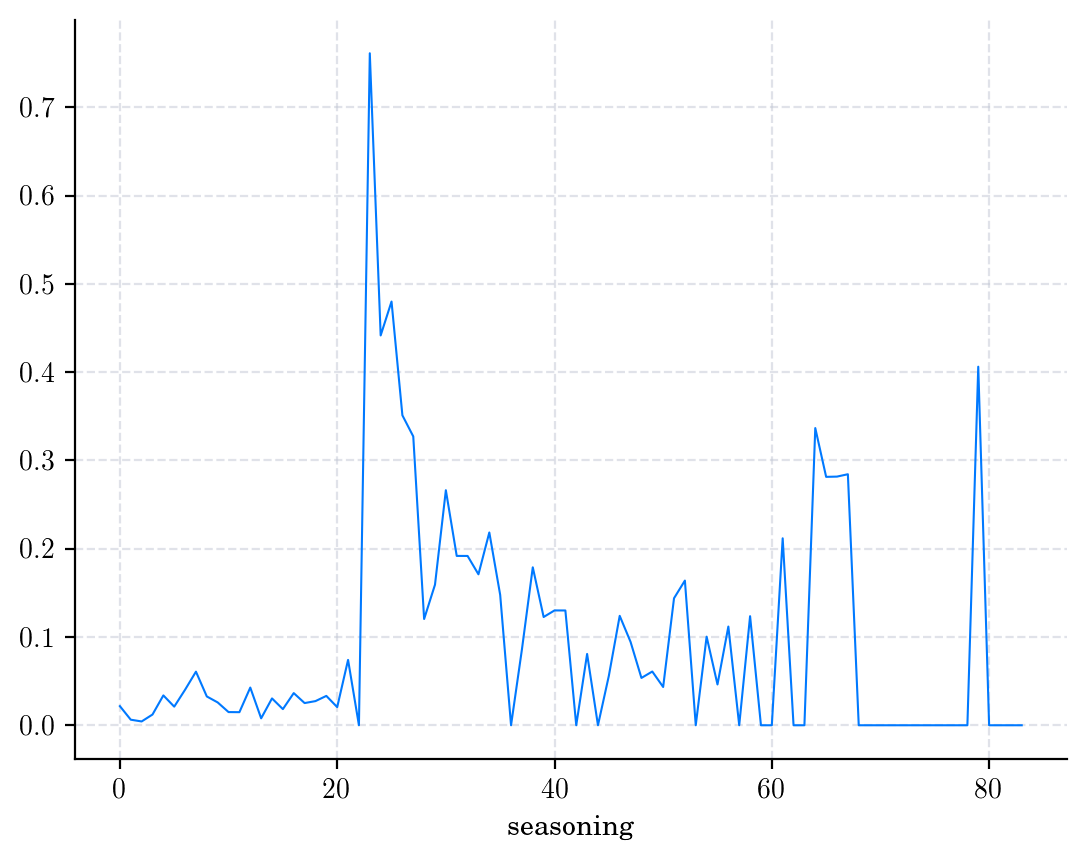

In [59]:
cpr.plot()
plt.show()

Question 4: Create a similar function for Default Curves ("CDR") 

In [60]:
cdr = portfolio.construct_portfolio_cdr()
cdr.head()

seasoning
0   0.00
1   0.00
2   0.02
3   0.01
4   0.02
dtype: float64

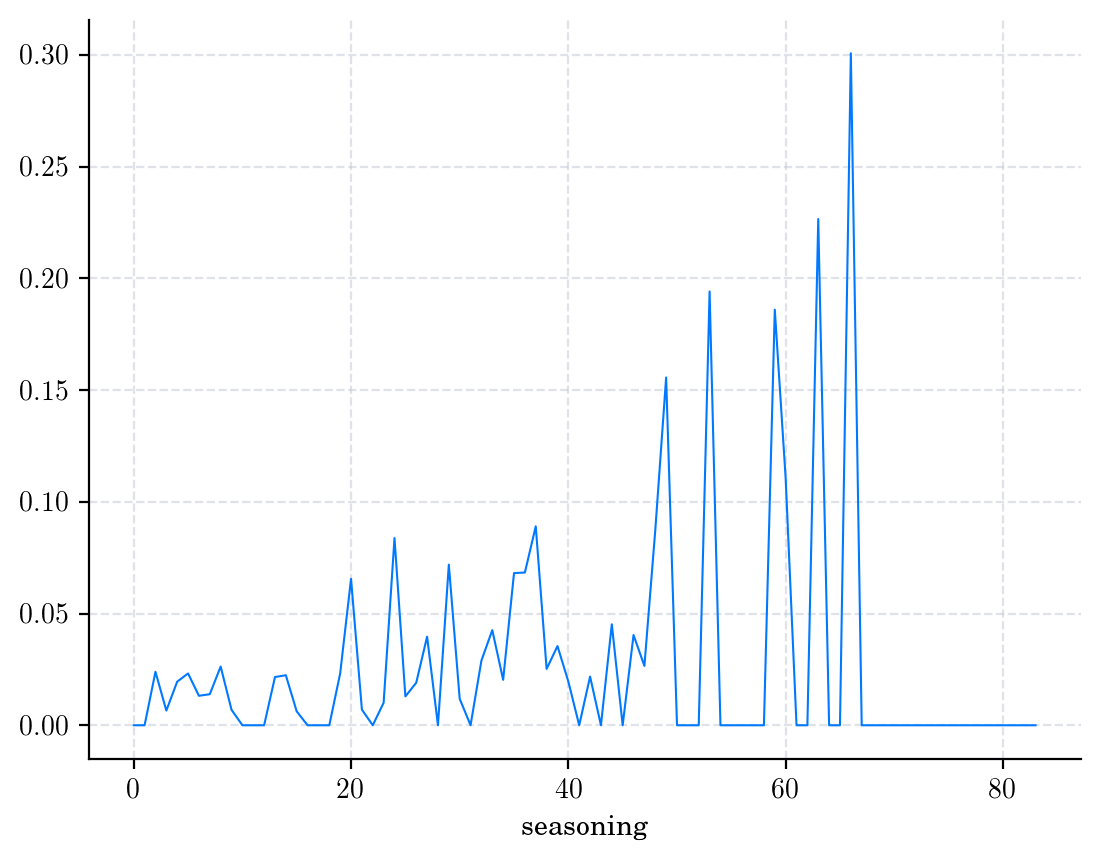

In [61]:
cdr.plot()
plt.show()

Question 6: Using your function,  calculate Prepayment and Default Curves (vs. Time to Reversion); split by Product

In [62]:
cdr_byproduct = portfolio.construct_portfolio_cdr(pivots=['time_to_reversion', 'product'])
cdr_byproduct.head()

product,1,2
time_to_reversion,,
-24,0.00,0.00
-23,0.00,0.00
-22,0.03,0.00
-21,0.01,0.00
-20,0.03,0.00


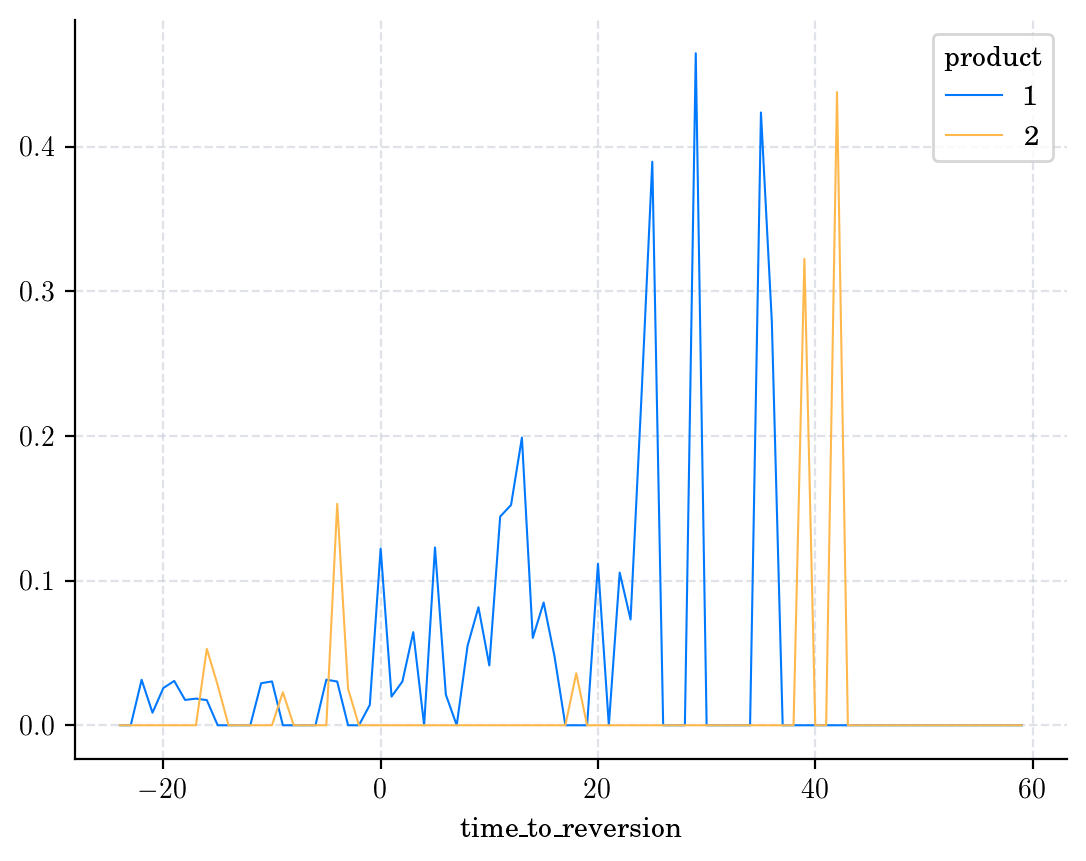

In [63]:
cdr_byproduct.plot()
plt.show()

In [64]:
cpr_byproduct = portfolio.construct_portfolio_cpr(pivots=['time_to_reversion', 'product'])
cpr_byproduct.head()

product,1,2
time_to_reversion,,
-24,0.03,0.00
-23,0.01,0.00
-22,0.01,0.00
-21,0.02,0.00
-20,0.02,0.07


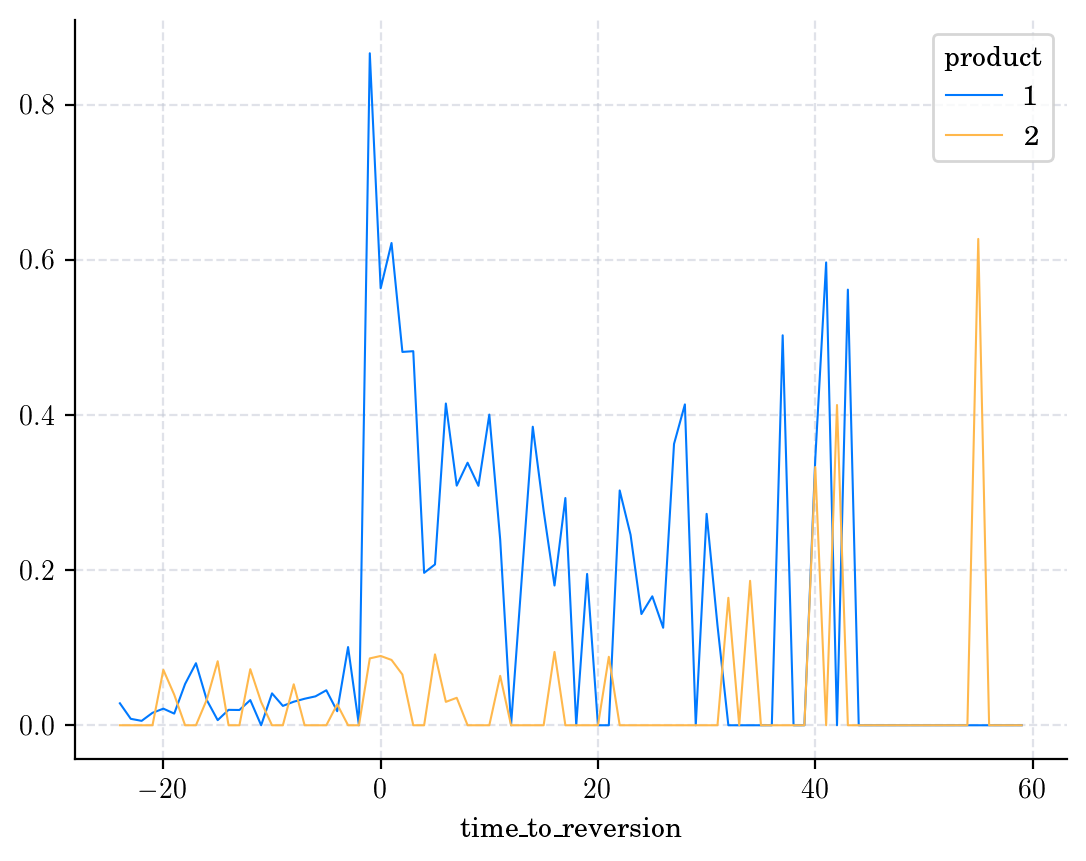

In [65]:
cpr_byproduct.plot()
plt.show()

In [66]:
RC = portfolio.construct_recovery_curve()
RC

months_since_default
-67   0.00
-66   0.00
-65   0.00
-64   0.00
-63   0.00
      ... 
 22   0.73
 23   0.68
 24   0.09
 25   0.09
 26   0.10
Length: 94, dtype: float64

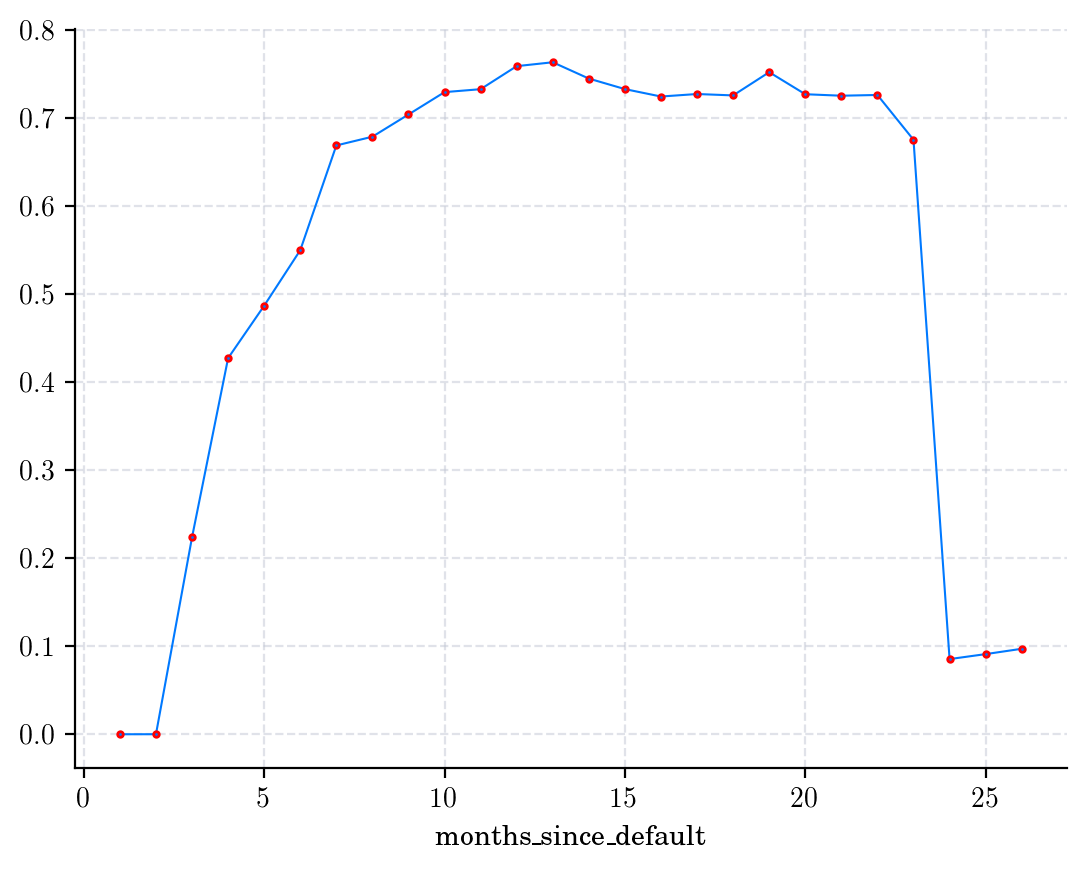

In [67]:
RC[RC.index > 0].plot(style='-o', ms=2, mec='r')
plt.show()

Question 7: Using your function, construct Recovery Curves split by year of default ("Default Vintage")

In [68]:
RCY = portfolio.construct_recovery_curve(pivots=['year_of_default'])
RCY

year_of_default,2020,2021,2022
months_since_default,,,
-67,NaN,NaN,0.00
-66,NaN,NaN,0.00
-65,NaN,NaN,0.00
-64,NaN,NaN,0.00
-63,NaN,NaN,0.00
...,...,...,...
22,0.08,0.87,NaN
23,0.08,0.84,NaN
24,0.09,NaN,NaN


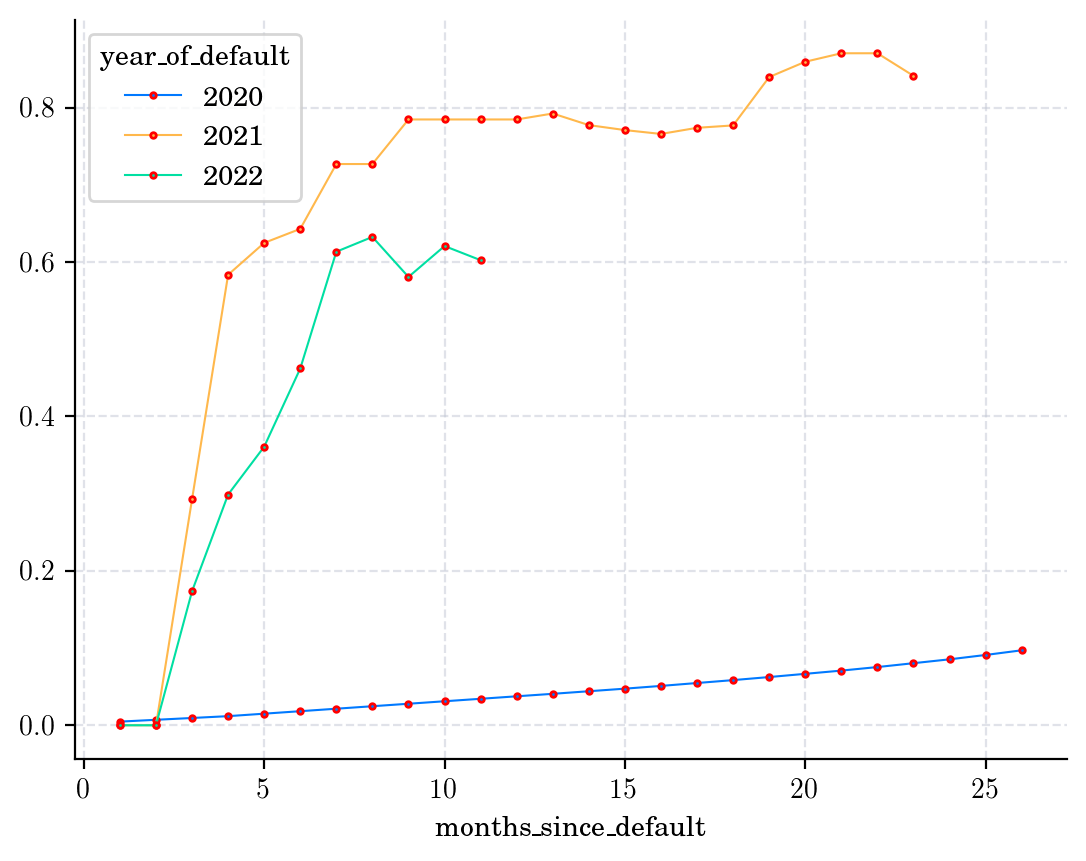

In [69]:
RCY[RCY.index > 0].plot(style='-o', ms=2, mec='r')
plt.show()

Question 8: Decompose your Recovery Curve in Q7 into two stage calibration:

(1) Probability of Recovery by Time Since Default and
(2) Recovery as a % of EAD

To express the expected recovery as the sum of recoveries by a given time after default using the law of total probability, we introduce the following notation


- $T$ = Time since default
- $P(T = t) $ = Probability of a recovery occurring at time $t$
- $R_t$ = Recovery rate as a % of EAD at time $t$
- $EAD$ = Exposure at Default
- $E[R_t]$ = Expected recovery rate as a percentage of EAD at time $t$


Using the law of total probability, the expected recovery by a given time $T$ can be written as:

$$
E[\text{Recovery}] = \sum_{t=0}^{T} P(T = t) \cdot E[\text{Recovery} \mid T = t]
$$

Where $$E[\text{Recovery} \mid T = t] $$ is the expected recovery amount given that the recovery occurs at time $t$.



Given that the recovery at time $t$ is $R_t \times EAD$, the expected recovery amount given a recovery occurs at time $t$ is:

$$
E[\text{Recovery} \mid T = t] = E[R_t] \cdot EAD
$$


Combining these, the overall expected recovery by a given time $T$ from default is:

$$
E[\text{Recovery by time T}] = EAD \cdot \sum_{t=0}^{T} P(T = t) \cdot E[R_t]
$$



Question 9: Build a Python Cashflow Model that allows the user to forecasts expected cashflows on a loan-by-loan basis using input CPR / CDR and Recovery Curves. A simple excel example has been given on the "Simple Mortgage Model" tab

In [70]:
from case.forecast_model import Loan, Model_Inputs, ForecastModel

CPR = portfolio.construct_portfolio_cpr()
CDR = portfolio.construct_portfolio_cdr()
n = len(CDR)

model_inputs = Model_Inputs({
    'CPR': CPR,
    'CDR': CDR,
    'months_for_reversion': CPR.index,
    'boe_rates_forecast': np.full(n, 0.02) # fixed for now

})

loan_data = Loan({
    'Months_Post_Reversion': -22,
    'Seasoning': 2,
    'current_balance': 100000,
    'Fixed Pre-Reversion Rate': 0.0394,
    'Post Reversion Margin': 0.0494,
    'Months to Maturity': 178,
    'repayment_method': 'Interest Only'
})

model = ForecastModel(model_inputs)
forecast_table = model.forecast(loan_data)

In [71]:
forecast_table.head()

,Expected_Opening_Perfornace,Expected Closing Default Balance,Defaults,Expected Balance Post Period Defaults,Expected Balance Pre Period Prepays,Expected Prepayments
0,"100,000.00","99,817.90",0.00,"100,000.00","100,000.00",182.10
1,"99,817.90","99,765.33",0.00,"99,817.90","99,817.90",52.56
2,"99,765.33","99,528.27",201.23,"99,564.10","99,564.10",35.83
3,"99,528.27","99,372.39",54.62,"99,473.65","99,473.65",101.27
4,"99,372.39","98,925.18",163.04,"99,209.35","99,209.35",284.16
